In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pandapower as pp
import pandapower.networks as pn
from torch_geometric.nn import GATConv, LayerNorm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Running on: {device}")

# --- 1. 修正后的 Cosine 调度器 ---
class CosineNoiseScheduler(nn.Module):
    def __init__(self, num_timesteps, s=0.008):
        super().__init__()
        # [修复] 必须显式保存这个属性，否则采样函数会报错
        self.num_timesteps = num_timesteps
        
        steps = num_timesteps + 1
        x = torch.linspace(0, num_timesteps, steps)
        alphas_cumprod = torch.cos(((x / num_timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        betas = torch.clip(betas, 0.0001, 0.9999)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        
        self.register_buffer('betas', betas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1.0 - alphas_cumprod))

    def add_noise(self, x0, t, noise=None):
        if noise is None: noise = torch.randn_like(x0)
        sqrt_alpha = self.sqrt_alphas_cumprod[t].view(-1, 1)
        sqrt_1_minus_alpha = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1)
        xt = sqrt_alpha * x0 + sqrt_1_minus_alpha * noise
        return xt, noise

# --- 2. 其他必要组件 ---
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = np.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class PhysicsGAT_DenoiseNet(nn.Module):
    def __init__(self, input_dim=3, edge_dim=2, hidden_dim=256, output_dim=1, heads=4):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        
        self.conv1 = GATConv(hidden_dim, hidden_dim // heads, heads=heads, concat=True, edge_dim=edge_dim)
        self.norm1 = LayerNorm(hidden_dim)
        self.conv2 = GATConv(hidden_dim, hidden_dim // heads, heads=heads, concat=True, edge_dim=edge_dim)
        self.norm2 = LayerNorm(hidden_dim)
        self.conv3 = GATConv(hidden_dim, hidden_dim // heads, heads=heads, concat=True, edge_dim=edge_dim)
        self.norm3 = LayerNorm(hidden_dim)
        
        self.out_proj = nn.Linear(hidden_dim, output_dim)
        self.act = nn.SiLU()

    def forward_with_time_expand(self, x, t, batch_index, edge_index, edge_attr):
        h = self.input_proj(x)
        t_emb = self.time_mlp(t)[batch_index]
        h = h + t_emb
        
        h_in = h
        h = self.conv1(h, edge_index, edge_attr=edge_attr)
        h = self.norm1(h + h_in)
        h = self.act(h)
        
        h = h + t_emb
        h_in = h
        h = self.conv2(h, edge_index, edge_attr=edge_attr)
        h = self.norm2(h + h_in)
        h = self.act(h)
        
        h = h + t_emb
        h_in = h
        h = self.conv3(h, edge_index, edge_attr=edge_attr)
        h = self.norm3(h + h_in)
        h = self.act(h)
        
        return self.out_proj(h)

# 3. 加载物理增强版模型
CONFIG = {'hidden_dim': 256, 'heads': 4, 'timesteps': 1000}
model = PhysicsGAT_DenoiseNet(input_dim=3, edge_dim=2, hidden_dim=CONFIG['hidden_dim'], heads=CONFIG['heads']).to(device)

# 确保路径正确，如果不确定是哪个文件，可以用这个通用的加载逻辑
try:
    model.load_state_dict(torch.load("../models/gnn_diffusion_ieee33_physics.pth", map_location=device))
    print("✅ 物理增强版模型加载成功 (Physics GAT)")
except FileNotFoundError:
    print("⚠️ 找不到 physics 模型，尝试加载普通 GNN 模型...")
    try:
        model.load_state_dict(torch.load("../models/gnn_diffusion_ieee33.pth", map_location=device))
        print("✅ 普通 GNN 模型加载成功")
    except:
        print("❌ 无法加载任何模型，请检查路径！")

model.eval()

# 4. 初始化修正后的调度器
scheduler = CosineNoiseScheduler(CONFIG['timesteps']).to(device)
print("✅ Scheduler 已修正并初始化。")

🚀 Running on: cuda
✅ 物理增强版模型加载成功 (Physics GAT)
✅ Scheduler 已修正并初始化。


In [6]:
# 加载原始数据 (Exp 1 的数据)
dataset = torch.load("../data/processed/ieee33_graph_data.pt", weights_only=False)
stats = torch.load("../data/processed/data_stats.pt", weights_only=False)

# 提取物理参数 (R, X)
def get_edge_data():
    net = pn.case33bw()
    r = net.line.r_ohm_per_km.values * net.line.length_km.values
    x = net.line.x_ohm_per_km.values * net.line.length_km.values
    attr = np.stack([r, x], axis=1)
    attr = np.concatenate([attr, attr], axis=0) # 双向
    # 归一化
    mean, std = attr.mean(axis=0), attr.std(axis=0)
    attr_norm = (attr - mean) / (std + 1e-6)
    
    src = np.concatenate([net.line.from_bus.values, net.line.to_bus.values])
    dst = np.concatenate([net.line.to_bus.values, net.line.from_bus.values])
    edge_index = torch.tensor(np.stack([src, dst]), dtype=torch.long).to(device)
    edge_attr = torch.tensor(attr_norm, dtype=torch.float32).to(device)
    return edge_index, edge_attr

edge_index, edge_attr = get_edge_data()

# 准备测试集 (Batch=500)
all_data_list = [d for d in dataset]
all_x = torch.stack([d.x for d in all_data_list]).to(device) # P, Q
all_y = torch.stack([d.y for d in all_data_list]).to(device) # V

test_size = 500
X_test = all_x[:test_size] # [500, 33, 2]
Y_test = all_y[:test_size] # [500, 33, 1]

print("✅ 测试数据准备就绪。")

✅ 测试数据准备就绪。


In [7]:
@torch.no_grad()
def sample_inpainting(model, scheduler, x_true, condition, mask, edge_index, edge_attr):
    """
    x_true: [B, N, 1] 真实的电压值 (用于在已知位置提供Ground Truth)
    condition: [B, N, 2] P, Q 条件 (假设已知)
    mask: [B, N, 1] 1=已知(Observed), 0=未知(Missing)
    """
    batch_size, num_nodes, _ = x_true.shape
    
    # 静态图结构构建
    edge_index_batch = edge_index.unsqueeze(1).repeat(1, batch_size, 1)
    edge_index_batch += torch.arange(batch_size, device=device).view(1, batch_size, 1) * num_nodes
    static_edge_index = edge_index_batch.view(2, -1)
    
    static_edge_attr = edge_attr.unsqueeze(0).repeat(batch_size, 1, 1).view(-1, 2)
    static_batch_idx = torch.arange(batch_size, device=device).view(-1, 1).repeat(1, num_nodes).view(-1)
    
    # 从纯噪声开始
    x = torch.randn_like(x_true)
    
    for i in tqdm(reversed(range(scheduler.num_timesteps)), desc="Inpainting"):
        t = torch.full((1,), i, device=device, dtype=torch.long)
        
        # --- 核心逻辑: Re-noising (将已知信息注入) ---
        # 我们不仅要让模型生成，还要强迫已知部分符合 x_true
        # 在这一步 t，真实的 x_true 应该长什么样？ -> 加噪到 t 时刻的 x_true_t
        noise = torch.randn_like(x_true)
        ts_nodes = t.repeat(batch_size * num_nodes)
        x_true_t, _ = scheduler.add_noise(x_true.view(-1, 1), ts_nodes, noise.view(-1, 1))
        x_true_t = x_true_t.view(batch_size, num_nodes, 1)
        
        # 融合：已知部分用 x_true_t，未知部分用模型当前的 x
        # x = Mask * x_true_t + (1 - Mask) * x
        x = mask * x_true_t + (1 - mask) * x
        
        # --- 标准去噪步 ---
        t_batch = t.repeat(batch_size)
        model_input = torch.cat([x.view(-1, 1), condition.view(-1, 2)], dim=-1)
        
        pred_noise = model.forward_with_time_expand(
            x=model_input, t=t_batch, 
            batch_index=static_batch_idx, 
            edge_index=static_edge_index, 
            edge_attr=static_edge_attr
        )
        
        alpha = scheduler.alphas_cumprod[i]
        beta = scheduler.betas[i]
        sqrt_1_minus_alpha = scheduler.sqrt_one_minus_alphas_cumprod[i]
        
        mean = (1 / torch.sqrt(1 - beta)) * (x.view(-1, 1) - (beta / sqrt_1_minus_alpha) * pred_noise)
        mean = torch.clamp(mean, -3.0, 3.0)
        
        if i > 0:
            noise = torch.randn_like(x.view(-1, 1))
            x_next = mean + torch.sqrt(beta) * noise
        else:
            x_next = mean
            
        x = x_next.view(batch_size, num_nodes, 1)
        
    return x

🚀 开始稀疏重构测试 (观测率: 20.0%)


Inpainting: 0it [00:00, ?it/s]

🎉 全局 RMSE: 0.0149 p.u.
🎉 未知节点恢复 RMSE: 0.0164 p.u.


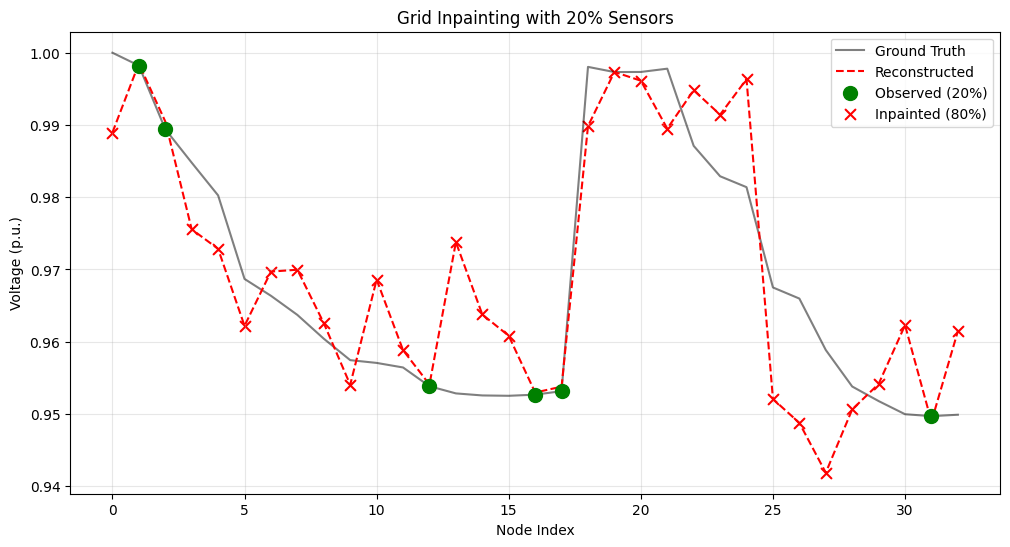

In [8]:
# 配置观测率 (Sparsity Ratio)
observation_ratio = 0.2  # 只保留 20% 的节点数据！
print(f"🚀 开始稀疏重构测试 (观测率: {observation_ratio*100}%)")

# 创建 Mask
# 随机选择 20% 的节点设为 1，其余为 0
batch_size, num_nodes, _ = X_test.shape
mask = torch.zeros_like(Y_test)
num_observed = int(num_nodes * observation_ratio)

# 为每个样本随机选择观测点
for k in range(batch_size):
    perm = torch.randperm(num_nodes)
    idx = perm[:num_observed]
    mask[k, idx, :] = 1.0

# 执行补全
x_inpainted = sample_inpainting(
    model, scheduler, 
    x_true=Y_test,       # Ground Truth (仅用于已知部分的约束)
    condition=X_test,    # P, Q
    mask=mask, 
    edge_index=edge_index, 
    edge_attr=edge_attr
)

# 反归一化
v_min, v_max = stats['v_min'], stats['v_max']
gen_v = (x_inpainted.cpu().numpy().flatten() + 1) / 2 * (v_max - v_min) + v_min
gt_v = (Y_test.cpu().numpy().flatten() + 1) / 2 * (v_max - v_min) + v_min

# 只计算“未知节点”的误差 (验证补全能力)
mask_np = mask.cpu().numpy().flatten()
missing_indices = np.where(mask_np == 0)[0]

rmse_all = np.sqrt(np.mean((gen_v - gt_v)**2))
rmse_missing = np.sqrt(np.mean((gen_v[missing_indices] - gt_v[missing_indices])**2))

print(f"🎉 全局 RMSE: {rmse_all:.4f} p.u.")
print(f"🎉 未知节点恢复 RMSE: {rmse_missing:.4f} p.u.")

# 绘图：展示一个样本的补全效果
sample_idx = 0
s, e = sample_idx*33, (sample_idx+1)*33
node_idx = np.arange(33)
mask_sample = mask[sample_idx].cpu().numpy().flatten()
observed_idx = np.where(mask_sample == 1)[0]
missing_idx = np.where(mask_sample == 0)[0]

plt.figure(figsize=(12, 6))
plt.plot(node_idx, gt_v[s:e], 'k-', alpha=0.5, label='Ground Truth')
plt.plot(node_idx, gen_v[s:e], 'r--', label='Reconstructed')
plt.scatter(node_idx[observed_idx], gt_v[s:e][observed_idx], c='g', s=100, zorder=5, label='Observed (20%)')
plt.scatter(node_idx[missing_idx], gen_v[s:e][missing_idx], c='r', marker='x', s=50, label='Inpainted (80%)')

plt.title(f"Grid Inpainting with {int(observation_ratio*100)}% Sensors")
plt.xlabel("Node Index")
plt.ylabel("Voltage (p.u.)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

🚀 开始 Ensemble 采样 (N=8)... 正在消除随机噪声...


Inpainting: 0it [00:00, ?it/s]

Inpainting: 0it [00:00, ?it/s]

Inpainting: 0it [00:00, ?it/s]

Inpainting: 0it [00:00, ?it/s]

Inpainting: 0it [00:00, ?it/s]

Inpainting: 0it [00:00, ?it/s]

Inpainting: 0it [00:00, ?it/s]

Inpainting: 0it [00:00, ?it/s]


✨ Ensemble 优化后全局 RMSE: 0.0125 p.u.
✨ Ensemble 优化后未知节点 RMSE: 0.0138 p.u.


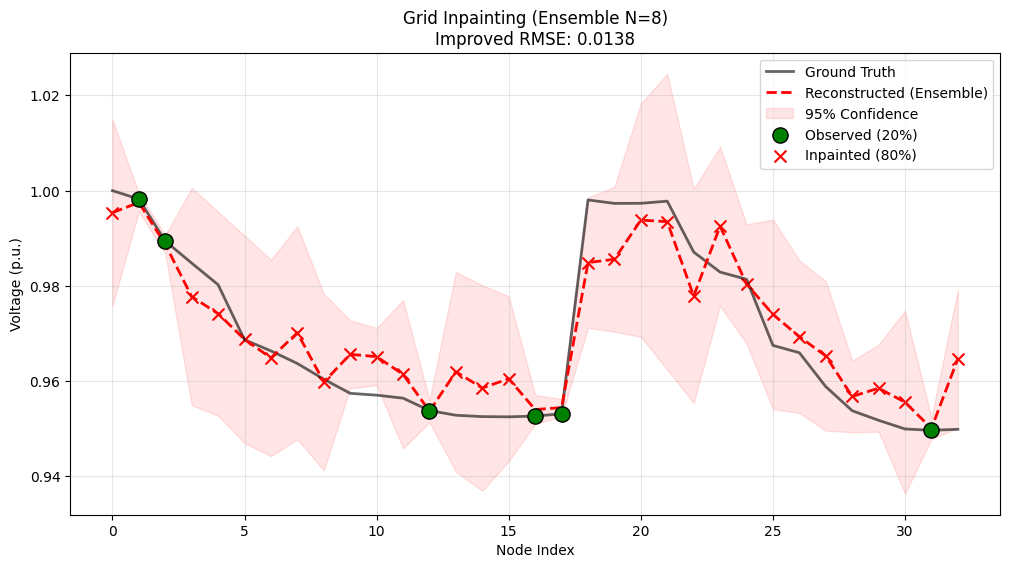

In [9]:
# [Cell 5] Ensemble Inpainting Strategy

def ensemble_inpainting(num_samples=8):
    print(f"🚀 开始 Ensemble 采样 (N={num_samples})... 正在消除随机噪声...")
    
    # 容器：存放每一次的预测结果
    all_preds = []
    
    for k in range(num_samples):
        # 每次采样都有不同的随机种子，产生不同的随机路径
        x_pred = sample_inpainting(
            model, scheduler, 
            x_true=Y_test, 
            condition=X_test, 
            mask=mask, 
            edge_index=edge_index, 
            edge_attr=edge_attr
        )
        all_preds.append(x_pred.cpu().numpy())
    
    # Stack & Mean
    # Shape: [N_samples, Batch, Nodes, 1]
    all_preds = np.stack(all_preds, axis=0)
    
    # 核心步骤：取平均
    ensemble_mean = np.mean(all_preds, axis=0)
    # 也可以计算不确定性 (标准差)
    ensemble_std = np.std(all_preds, axis=0)
    
    return ensemble_mean, ensemble_std

# 执行 Ensemble
x_ensemble_norm, x_std_norm = ensemble_inpainting(num_samples=8)

# 反归一化
gen_v = (x_ensemble_norm.flatten() + 1) / 2 * (v_max - v_min) + v_min
# 真实值 (保持不变)
gt_v = (Y_test.cpu().numpy().flatten() + 1) / 2 * (v_max - v_min) + v_min

# 计算新的 RMSE
mask_np = mask.cpu().numpy().flatten()
missing_indices = np.where(mask_np == 0)[0]

rmse_all = np.sqrt(np.mean((gen_v - gt_v)**2))
rmse_missing = np.sqrt(np.mean((gen_v[missing_indices] - gt_v[missing_indices])**2))

print(f"\n✨ Ensemble 优化后全局 RMSE: {rmse_all:.4f} p.u.")
print(f"✨ Ensemble 优化后未知节点 RMSE: {rmse_missing:.4f} p.u.")

# --- 绘图对比 ---
# 依然画第 0 个样本
sample_idx = 0
s, e = sample_idx*33, (sample_idx+1)*33
node_idx = np.arange(33)
mask_sample = mask[sample_idx].cpu().numpy().flatten()
observed_idx = np.where(mask_sample == 1)[0]
missing_idx = np.where(mask_sample == 0)[0]

plt.figure(figsize=(12, 6))

# 1. Ground Truth
plt.plot(node_idx, gt_v[s:e], 'k-', alpha=0.6, linewidth=2, label='Ground Truth')

# 2. Reconstructed (Ensemble Mean)
plt.plot(node_idx, gen_v[s:e], 'r--', linewidth=2, label='Reconstructed (Ensemble)')

# 3. Uncertainty Band (置信区间)
# 展示模型的不确定性范围 (Mean ± 2*Std)
std_sample = x_std_norm.flatten()[s:e] * (v_max - v_min) / 2
plt.fill_between(node_idx, gen_v[s:e] - 2*std_sample, gen_v[s:e] + 2*std_sample, color='red', alpha=0.1, label='95% Confidence')

# 4. Markers
plt.scatter(node_idx[observed_idx], gt_v[s:e][observed_idx], c='g', s=120, zorder=5, edgecolors='k', label='Observed (20%)')
plt.scatter(node_idx[missing_idx], gen_v[s:e][missing_idx], c='r', marker='x', s=60, label='Inpainted (80%)')

plt.title(f"Grid Inpainting (Ensemble N=8)\nImproved RMSE: {rmse_missing:.4f}")
plt.xlabel("Node Index")
plt.ylabel("Voltage (p.u.)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()